In [ ]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.utils.data import random_split , DataLoader
import torchvision
from torchvision.utils import make_grid 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
data_path = '/content/drive/MyDrive/Garbage_Classification DataSet/Garbage classification.zip (Unzipped Files)/Garbage classification'

In [ ]:
img_size = 120
img_transformed = transforms.Compose([
                                      transforms.Resize((img_size , img_size)),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485,0.456,0.406] , std=[0.229,0.224,0.225])
])

In [ ]:
image_data = ImageFolder(root=data_path , transform=img_transformed)

In [ ]:
print(len(image_data.imgs))
print(image_data.classes)
print(image_data.class_to_idx)

2527
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
training_data , val_data , testing_data  = random_split(image_data , [1500 , 827 , 200])

len(training_data) , len(testing_data) , len(val_data)

(1500, 200, 827)

In [ ]:
train_loader = DataLoader(training_data , batch_size=50 , shuffle=True)
val_loader = DataLoader(val_data , batch_size=50 , shuffle=True)

In [ ]:
for img , label in train_loader:
  print(img.shape)
  break

torch.Size([50, 3, 120, 120])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


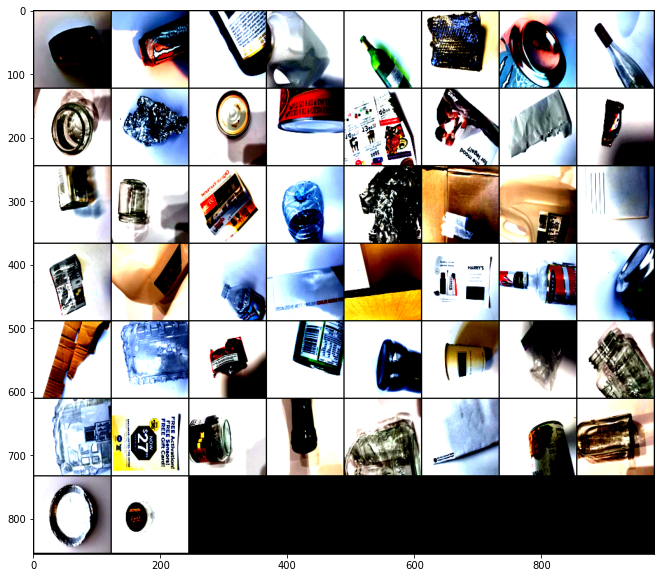

In [ ]:
def img_show(data):
  for img , label in data:
    plt.figure(figsize=(15,10))
    plt.imshow(make_grid(img , row_size=10).permute(1,2,0))
    plt.show()
    break
img_show(train_loader)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN , self ).__init__()
    self.cnn1 = nn.Conv2d(in_channels= 3,out_channels= 100, kernel_size = 3)   # (100 - 3)+1 = 98
    self.cnn2 = nn.Conv2d(in_channels= 100,out_channels= 250, kernel_size = 3)   # (100 - 3)+1 = 98
    self.cnn3 = nn.Conv2d(in_channels= 250,out_channels= 700, kernel_size = 3)   # (100 - 3)+1 = 98
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear( 13*13*700, 100)
    self.fc2 = nn.Linear(100 , 50)
    self.fc3 = nn.Linear(50 , 6)
    self.reLu = nn.ReLU()

  def forward(self , x): 

    # convo1 118 118 100    ((imageshape(120) - kernel size(3) + poolinig*2)/strid) +1
    # pooling 59 59 100   devide 2 of size (118/2)  output channel is as it is 
    # convo2 57 57 250       imageshape(59) - kernel size(3) /poolinig*2) +1
    # pooling 28 28 250     devide 2 of size (57/2)  output channel is as it is 
    # convo2 26 26 700       imageshape(28) - kernel size(3) /poolinig*2) +1
    # pooling 13 13 700     devide 2 of size (26/2)  output channel is as it is 


    out = self.pool(self.reLu(self.cnn1(x)))   
    out = self.pool(self.reLu(self.cnn2(out)))
    out = self.pool(self.reLu(self.cnn3(out)))
    out = out.view(-1 ,13*13*700 )
    out = self.reLu(self.fc1(out))
    # out = nn.Dropout(0.2)
    out = self.reLu(self.fc2(out))
    # out = nn.Dropout(0.2)
    out = self.fc3(out)
    return out


In [ ]:
model = CNN()
model.to(device)
model.parameters

<bound method Module.parameters of CNN(
  (cnn1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(100, 250, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(250, 700, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=118300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (reLu): ReLU()
)>

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)

In [ ]:
def train_test_Model(loss_fn , optimizer , epoches = 20):
  training_acc = []
  training_loss = []
  testing_acc = []
  testing_loss = []

  for epoch in range(epoches):
    train_acc = 0.0
    train_loss = 0.0

    model.train()

    for images , labels in train_loader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output , labels)
      loss.backward()
      optimizer.step()
      prediction = torch.argmax(output , 1)
      train_acc += (prediction == labels).sum().item()
      train_loss += loss.item()
    training_acc.append(train_acc / len(training_data))
    training_loss.append(train_loss / len(train_loader))

    model.eval()

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():
      for images , labels in val_loader:

        images = images.to(device)
        labels = labels.to(device)
      
        output = model(images)
        loss = loss_fn(output , labels)
      
        prediction = torch.argmax(output , 1)
        test_acc += (prediction == labels).sum().item()
        test_loss += loss.item()
      testing_acc.append(test_acc / len(val_data))
      testing_loss.append(test_loss / len(val_loader))
    print(f"Epochs:{epoch+1}, Training Accuracy:{train_acc/len(training_data):.2f}, Training Loss:{train_loss/len(train_loader):.2f}, Validation Accuracy:{test_acc/len(val_data):2f}, Validation Loss:{test_loss/len(val_loader):.2f}")
  plt.title("Accuracy Vs Epochs")
  plt.plot(range(20), training_acc, label ="Training Accuracy")
  plt.plot(range(epoches), testing_acc, label = "Validation Accuracy")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()

  plt.title("Loss Vs Epochs")
  plt.plot(range(epoches), training_loss, label ="Training Loss")
  plt.plot(range(epoches), testing_loss, label = "Validation Loss")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()


Epochs:1, Training Accuracy:0.28, Training Loss:1.74, Validation Accuracy:0.403869, Validation Loss:1.49
Epochs:2, Training Accuracy:0.45, Training Loss:1.39, Validation Accuracy:0.480048, Validation Loss:1.26
Epochs:3, Training Accuracy:0.52, Training Loss:1.21, Validation Accuracy:0.548972, Validation Loss:1.19
Epochs:4, Training Accuracy:0.57, Training Loss:1.11, Validation Accuracy:0.562273, Validation Loss:1.14
Epochs:5, Training Accuracy:0.59, Training Loss:1.04, Validation Accuracy:0.588875, Validation Loss:1.08
Epochs:6, Training Accuracy:0.62, Training Loss:0.93, Validation Accuracy:0.580411, Validation Loss:1.09
Epochs:7, Training Accuracy:0.69, Training Loss:0.84, Validation Accuracy:0.623942, Validation Loss:1.04
Epochs:8, Training Accuracy:0.72, Training Loss:0.77, Validation Accuracy:0.567110, Validation Loss:1.24
Epochs:9, Training Accuracy:0.74, Training Loss:0.72, Validation Accuracy:0.650544, Validation Loss:1.01
Epochs:10, Training Accuracy:0.77, Training Loss:0.63, 

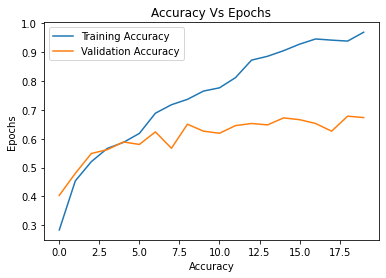

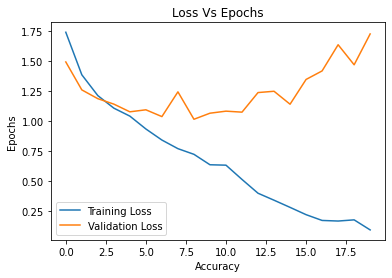

In [ ]:
train_test_Model(loss_func , optimizer)

In [ ]:
def predict_img(img):
  img = img.to(device)
  x = img.unsqueeze(0)
  y = model(x)
  prediction = torch.argmax(y , 1)
  return image_data.classes[prediction]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label paper prediction label paper


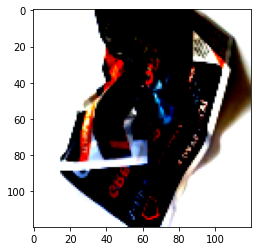

In [ ]:
image , label = testing_data[5]    
plt.imshow(image.permute(1,2,0))
print("Actual Label", image_data.classes[label] , "prediction label" , predict_img(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label glass prediction label glass


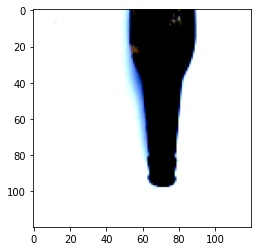

In [ ]:
image , label = testing_data[15]
plt.imshow(image.permute(1,2,0))
print("Actual Label", image_data.classes[label] , "prediction label" , predict_img(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label plastic prediction label plastic


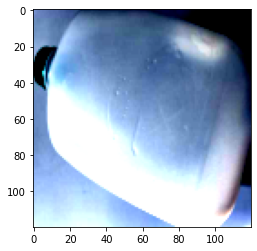

In [ ]:
image , label = testing_data[25]
plt.imshow(image.permute(1,2,0))
print("Actual Label", image_data.classes[label] , "prediction label" , predict_img(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label plastic prediction label plastic


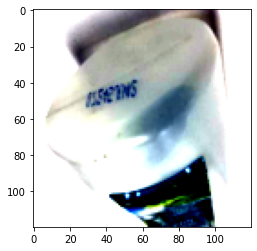

In [ ]:
image , label = testing_data[150]
plt.imshow(image.permute(1,2,0))
print("Actual Label", image_data.classes[label] , "prediction label" , predict_img(image))